# Text classification with a 2-layer neural network

## 1. Task description

### Text classification with neural networks
In the following sections, you will implement a simple neural network for text classification and train it on the [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/). 
The goal of text classification is, given an input text, to assign to it one of $K$ mutually exclusive labels. The most basic neural network consists of several feedforward fully-connected layers. Since text is a sequence of tokens (or characters), the most commonly used neural networks in NLP are [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), which learn well from sequential data. However, regular feedforward neural networks are still widely used as baselines or parts of more complex models. In this assignment, you will implememnt a simple feed forward neural network and train it with [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) on a subset of the [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/).


### 20 Newsgroups dataset
This dataset is a popular benchmark for classification models. It consists of $20000$ newsgroups documents, where each document has an associated label, selected out of $K=20$ classes (different newsgroups). Each class has roughly the same number of documents, making this dataset balanced. For for faster computation, here we will only use a small subset of classes, which consists of the following newsgroups: `comp.os.ms-windows.misc`, `rec.motorcycles`, `sci.space`, and `talk.politics.misc`. Each group contains roughly training $500$ samples. Thus, in total we will have a dataset with $4$ classes and slightly over $2000$ samples.

[Scikit-learn library](https://scikit-learn.org) has a convenient way of loading the 20 Newsgroups dataset, so we will use it to fetch the dataset and look at the document representation.

Execute the cell below to make sure your environment is fully set up. You are free to import any additional [standard Python libraries](https://docs.python.org/3/library/), however, the notebook can be completed without doing so. External libraries other than the ones listed below are not permitted.

In [0]:
!pip install -q papermill
import random
import string
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm import tqdm

plt.style.use('seaborn')
%matplotlib inline

    100% |████████████████████████████████| 51kB 3.9MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.


In [0]:
categories = ['comp.os.ms-windows.misc', 'rec.motorcycles', 'sci.space', 'talk.politics.misc', ]
dataset = fetch_20newsgroups(subset='train', categories=categories, data_home='.')

In [0]:
print('Samples:', len(dataset.data))
print('Categories:', len(dataset.target_names))

Samples: 2247
Categories: 4


Let's print a random example to see what it looks like.

In [0]:
random_sample_idx = random.randrange(len(dataset.data))
print('Label:', dataset.target_names[dataset.target[random_sample_idx]], '\n')
print(dataset.data[random_sample_idx])

Label: sci.space 

From: nsmca@aurora.alaska.edu
Subject: Moon Colony Prize Race! $6 billion total?
Lines: 26
Nntp-Posting-Host: acad3.alaska.edu
Organization: University of Alaska Fairbanks

I think if there is to be a prize and such.. There should be "classes"
such as the following:

Large Corp.
Small Corp/Company (based on reported earnings?)
Large Government (GNP and such)
Small Governemtn (or political clout or GNP?)
Large Organization (Planetary Society? and such?)
Small Organization (Alot of small orgs..)

The organization things would probably have to be non-profit or liek ??

Of course this means the prize might go up. Larger get more or ??
Basically make the prize (total purse) $6 billion, divided amngst the class
winners..
More fair?

There would have to be a seperate organization set up to monitor the events,
umpire and such and watch for safety violations (or maybe not, if peopel want
to risk thier own lives let them do it?).

Any other ideas??
==
Michael Adams, nsmca@acad

### Text representation for neural networks

As you can see, the documents are quite long and diverse. However, documents within each class contain some specific words that are less likely to be used in the documents from other classes. Our model will leverage this fact to perform text classification. In order to do that, we need to convert each document into numeric form. One of the simplest and most popular representations in NLP is the *multi-hot representation*. In this representation, each document $d$ is represented as a vector $\mathbf{x}$ of length $|V|$, where $V$ is the vocabulary - that is, a set of all possible words $v$, used in the whole dataset. The vector $\mathbf{x}$ contains $1$ on the $i$th position if the corresponding word $v_i$ was used in the document $d$, and $0$ otherwise.

Finally, we would need to convert the labels (`dataset.target`) to a matrix of one-hot vectors to use it to train the network.

The cell below will be used for unit tests. Please do not modify it.

In [0]:
# DO NOT MODIFY THIS CELL

docs_toy = [
"""
Hi!

How are you?

""",
"""
Do you have a dog?
"""
]
docs_toy_labels = np.array([0, 1])

In [0]:
print('First document:', docs_toy[0])
print('Second document:', docs_toy[1])

First document: 
Hi!

How are you?


Second document: 
Do you have a dog?



In [0]:
print('Labels:\n', docs_toy_labels)

Labels:
 [0 1]


### 1.1 
#### (2 points)

Complete the code in the `tokenize_doc` function that returns a list of tokens for a given document.

---
__Notes__:
- You can use the `string.punctuation` to get the punctuation characters
- You can use the `string.whitespace`  to get all whitespace characters


In [0]:
def tokenize_doc(doc):
    """
        Convert the input document into a list of tokens, discarding all punctuation and lowercasing the tokens
        doc: string

        return list of strings
    """


    # discard all punctuation
    doc2 = doc.translate(str.maketrans('', '', string.punctuation))

    # replace all whitespace characters with just space
    # split doc into tokens by space
    # discard empty tokens and lowercase
    doc2 = doc2.lower()
    tokens = doc2.split()
    return tokens

In [0]:
docs_toy_tokenized = [tokenize_doc(d) for d in docs_toy]


If you implememnted this function correcrtly, the documents would look like this:
```
['hi', 'how', 'are', 'you']
```
```
['do', 'you', 'have', 'a', 'dog']
```


In [0]:
print('First document tokenized:\n', docs_toy_tokenized[0])
print('Second document tokenized:\n', docs_toy_tokenized[1])

First document tokenized:
 ['hi', 'how', 'are', 'you']
Second document tokenized:
 ['do', 'you', 'have', 'a', 'dog']


In [0]:
# DO NOT MODIFY THIS CELL
pm.record('tokenization.test_docs.0', docs_toy_tokenized[0])
pm.record('tokenization.test_docs.1', docs_toy_tokenized[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  


### 1.2
#### (1 point)

Complete the code in `build_vocab`. If the `min_count` argument is `None`, you should not discard any tokens.

---
__Notes__:
- Hint: you might find the `Counter` class from the `collections` library and `from_iterable` method from `itertools.chain` useful here.

In [0]:
def build_vocab(docs, min_count=None):
    """
        Build the vocaublary mapping (that is, the correspondance between the token and its numeric id)
        docs: a list of tokenized documents
        min_count (optional): int, discard tokens that appeared less than min_count times

        return dictionary str -> int
    """

    # count all tokens in all documents and filter those that appear less than min_count  
    word_counter = Counter(x for xs  in docs for x in set(xs))
    dictionary = dict(word_counter)

    if min_count is not None:
        pass 
        uniqueWords = []
        for k, v in dictionary.items():
          if v >= min_count:
            uniqueWords.append(k)
        docs_sorted = sorted(uniqueWords)    
        
    else:
        pass 
        flat_list = [item for sublist in docs for item in sublist]
        uniqueWords = []
        for i in flat_list:
          if not i in uniqueWords:
            uniqueWords.append(i)
        docs_sorted = sorted(uniqueWords)   
    #create the vocabulary mapping
    l = [i for i in range(len(docs_sorted))]
    vocab = dict(zip(docs_sorted, l))
        
    return vocab

In [0]:
flat_list = [item for sublist in docs_toy_tokenized for item in sublist]
print(flat_list)
d = sorted(flat_list)
print(len(d))


['hi', 'how', 'are', 'you', 'do', 'you', 'have', 'a', 'dog']
9


In [0]:
vocab = build_vocab(docs_toy_tokenized)

If you implememnted this function correcrtly, the vocabulary would contain 8 tokens and similar to the following:
```
{'a': 0, 'are': 1, 'do': 2, 'dog': 3, 'have': 4, 'hi': 5, 'how': 6, 'you': 7}
```

In [0]:
print('Vocabulary:\n', vocab)

Vocabulary:
 {'a': 0, 'are': 1, 'do': 2, 'dog': 3, 'have': 4, 'hi': 5, 'how': 6, 'you': 7}


In [0]:
# DO NOT MODIFY THIS CELL
pm.record('vocab.test_docs', vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


### 1.3 
#### (1 point)

Complete the code in the `doc_to_multihot` function that tranforms the input document to its' multi-hot representation. 

---
__Notes__:
- Recall that multi-hot representation of a given document should return a vector containing ones at the positions of the words present in the document and zeros at all the other positions.




In [0]:
def doc_to_multihot(doc, vocab):
    """
        Convert a document to a multihot representation
        doc: str, a tokenized document
        vocab: dict, vocabulary mapping

        return np.array, shape=(|V|,)
    """

    # create a vector of zeros of the shape (|V|, )
    x = np.zeros(len(vocab))

    # set the corresponding dimensions to 1
    for k,v in vocab.items():
      for word in doc:
        if k == word:
          x[vocab[k]] = 1
    return x

In [0]:
docs_toy_multi_hot = [doc_to_multihot(doc, vocab) for doc in docs_toy_tokenized]

If you implemented this function correcrtly, the documents in multi-hot representation would look similar to the following
```
[0. 1. 0. 0. 0. 1. 1. 1.]
```
```
[1. 0. 1. 1. 1. 0. 0. 1.]
```

Notice how these documents have $1$ in the dimensions matching to the tokens indices from the vocabulary. In particular, since both documents have the token `you`, they both have $1$ in the corresponding dimension.

In [0]:
print('First document multi-hot:\n', docs_toy_multi_hot[0])
print('Second document multi-hot:\n', docs_toy_multi_hot[1])

First document multi-hot:
 [0. 1. 0. 0. 0. 1. 1. 1.]
Second document multi-hot:
 [1. 0. 1. 1. 1. 0. 0. 1.]


In [0]:
# DO NOT MODIFY THIS CELL
pm.record('multihot.test_docs.0', docs_toy_multi_hot[0].tolist())
pm.record('multihot.test_docs.1', docs_toy_multi_hot[1].tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  


### 1.4 
#### (2 points)

Because later on it will be easier to work with true labels as with one-hot encoded vectors rather than with single integers, you will now need to complete the code in `labels_to_onehot` that converts a vector of class labels to a one-hot representation.

---
__Notes__:
- For example, if there were $k=3$ classes in your dataset and the true labels vector looked like $\begin{bmatrix} 2 \\ 1 \\ 0 \\ 1 \end{bmatrix}$ (assuming there were $N=4$ examples), then the ultimate one-hot representation of the labels would be the following: $\mathbf{y} = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0 \\ 0 & 1 & 0\end{bmatrix}$




In [0]:
def labels_to_onehot(labels):
    """
        Convert the indices to one-hot representation
        labels: np.array of labels, shape=(N,)

        return np.array, shape=(N, k)
       """
    #labels defines the columns of nonzero elements in the output array
     l = [i for i in range(len(labels))]
    unique= np.unique(labels)
    vocab = dict(zip(unique, l))
    
    n_classes = len(set(labels))
    n_samples = len(labels)
    # create a matrix of zeros of shape (n_samples, n_classes)
    one_hot = np.zeros((n_samples, n_classes))
    # fill one-hot values
    a = []
    for label in labels:
        for k,v in vocab.items():
            if k == label:
                a.append(vocab[k])
    one_hot[np.arange(n_samples), a] = 1
    return one_hot

In [0]:
docs_toy_labels_onehot = labels_to_onehot(docs_toy_labels)

If you implemented this function correcrtly, the one-hot labels would look like this:
```
[[1. 0.]
 [0. 1.]]
```

In [0]:
print('Test labels one-hot:\n', docs_toy_labels_onehot)

Test labels one-hot:
 [[1. 0.]
 [0. 1.]]


In [0]:
# DO NOT MODIFY THIS CELL
pm.record('onehot.test_labels', docs_toy_labels_onehot.tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


## 2. Neural networks overview

### Introduction
Neural networks (NNs) are machine learning alrogithms that are designed to capture patterns in a way similar to what human brain does. NNs are very efficient at discovering latent structures in unlabeled data and automatically extracting (or learning) relevant features.

In principle, there exist various NN architectures that are commonly applied to different problems. Essentially, every neural network consists of a set of computational units called neurons. Every neuron processes the input signal, computes the output, and passes it further to the next neuron. Altogether neurons can recognize complex patterns. Our current task will be focused on the simplest type of a neural network - the so-called fully-connected neural network.

### Fully-connected neural network
Fully-connected neural networks can be viewed as a stack of layers, where every layer consists of an arbitrary number of neurons. Conventionally, the first layer is called an input layer, all the middle layers are referred to as hidden layers, and the last layer is called the output layer. The output layer is responsible for making ultimate high-level decisions and generating the predictions. The diagram of the feed-forward neural network with one layer (it is common to only count the hidden layers):


<center>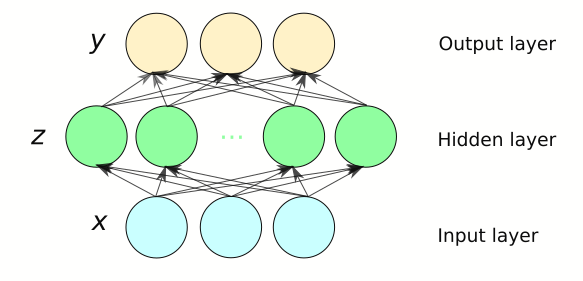</center>

The depth of a neural network is one of its key features. Each node of a single layer combines the outputs of the nodes in the previous layer and adds them up in different proportions, i.e. weights, and applies a non-linear function to the obtained value. Non-linearity is important, since a stack of linear layers without non-linear activations would be equivalent to just one single linear layer, which reduces the capacity of a neural network to recover the elaborate structures in the input data. Formally, if we denote the weights and the biases of the $i$-th layer as matrices $W^i$ and $\mathbf{b}$ respectively, and the input example feature vector as $\mathbf{x}$, then the $i$-th linear layer's transformation is as follows:


$$ \mathbf{z}^{(i)} = W^{(i)}\mathbf{x} + \mathbf{b} $$
$$ \mathbf{a}^{(i)} = f\left(\mathbf{z}^{(i)}\right)$$

where $f$ is the mentioned non-linear function called the activation function. There is a number of activation functions that are widely used in Deep Learning. In classification tasks, the dimension of the last layer equals the number of classes $k$ and the activation function of the last layer is, typically, either the sigmoid function (for binary classification problmes) or the softmax function (which is a generalization of the sigmoid function over multiclass classification problems).

### Softmax function and predictions
Given a vector $\mathbf{z}$ of the dimension $k$, the softmax function computes the vector with the following components:

$$ \text{softmax}\left(\mathbf{z}\right)_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}} $$

In other words, the softmax function first exponentiates the vector (elementwise) and then normalizes it such that all the components would add up to 1. In the output layer the resulting vector can be interpreted as a probability distribution over the number of classes. The network then makes its prediction through selecting a class with the maximum associated probability:

$$ \hat{y}_{pred} = \underset{j \in 1..k}{\text{argmax}}\left[\text{softmax}\left(\mathbf{z}\right)\right] $$

One interesting property of the softmax function is that it is invariant to constant offsets, i.e. $\text{softmax}\left(\mathbf{z}\right) = \text{softmax}\left(\mathbf{z} + \mathbf{c}\right)$, where $\mathbf{c}$ is a broadcasted vector of equal constant values. 

To sum up, for a single-layer neural network the predicted probability distributions are computed as:

$$ \mathbf{\hat{y}} = \text{softmax}\left(W\mathbf{x} + \mathbf{b}\right) $$

### Training
Simply put, training of a neural network reduces to learning its preliminarily initialized weights such that the learned weights would optimize a given objective. The most popular optimization algorithm used in Deep Learning is gradient descent. The training objective is usually formulated as maximization of the likelihood of the training data, which for classification tasks is equivalent to minimizing the cross-entropy function:

$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n \rightarrow \min_{W, b}$$

where $\hat{y}_n$ is the predicted probability of the correct class $y_n$ for the $n$-th training example and $N$ is the total number of training examples. In order to reduce overfitting, an additional term penalizing large weights is added to the loss function as:

$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n + \lambda \Vert W\Vert ^2 \rightarrow \min_{W, b}$$


The actual training is done in iterations such that after every iteration the network produces the predictions, computes the value of the loss function based on the predictions and the ground-truth labels, calculates the gradients through a technique called backpropagation, and then uses the derived gradients to update the weights (a step of the gradient descent algorithm). Backpropagation is the heart of neural networks algorithm; it calculates the gradients of the loss function with respect to every trained weight through application of a series of chain rules. According to the gradient descent algorithm, the weights of the network are updated as:

$$ W_{ij} \leftarrow W_{ij} - \alpha\frac{\partial \mathcal{L}}{\partial W_{ij}} $$

$$ b_{i} \leftarrow b_{i} - \alpha\frac{\partial \mathcal{L}}{\partial b_{i}} $$

where $\alpha$ is a hyperparameter called learning rate that adjusts the magnitude of the weight updates.

In practice, training is done in batches: instead of processing one training instance at a time, a network receives multiple examples which are processed in parallel. Besides the computation efficiency, this approach also produces a better estimate of the gradients.

---
## Now let's code it up!
---


## 3. Step-by-step single-layer network implementation

The cell below will be used for unit tests. Please do not modify it.

In [0]:
# DO NOT MODIFY THIS CELL

# 5 features x 3 classes
W_toy = np.array([[0.2, -0.3, 0.5],
                 [-0.9, 0.6, 0.4],
                 [0.1, 0.7, -0.2],
                 [0.6, 0.1, -0.3],
                 [0.7, -0.1, 0.6]])

# 3 classes
b_toy = np.array([[0.05, 0.1, -0.2]])

# 4 examples x 5 features
x_toy = np.array([[-1.0, -0.7, 0.3, 0.8, 0],
                 [0.5, -0.2, 0.6, 0, -0.4],
                 [0.1, 0, -0.4, -0.1, -0.2],
                 [0.6, 0.7, 0.2, 0.1, 0.4]])

# 3 classes one-hot
y_true_toy = np.array([[0, 1, 0],
                      [1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])

### 3.1
#### (1 point)

Using the definition of a neural network linear layer, complete the code in `linear` function. Recall that

$$ \mathbf{z}^{(i)} = W^{(i)}\mathbf{x} + \mathbf{b} $$

---
__Notes__:

- __From now on, all the computations should be done in batches__, i.e. instead of a single example vector with the shape $[1\times d]$ the network will take batches with the shape $[m\times d]$.
- Note that numpy arrays support [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html): during arithmetic operations, smaller arrays get automatically reshaped to make the shapes of operands compatible. You can take advantage of broadcasting starting from the cell below and in the subsequent cells.


In [0]:
def linear(x, W, b):
    """
        Compute output of linear transformation given x, W, b
        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        b: np.array, shape=[1, k] biases

        return np.array, shape=[m, k]
    """
    # place your code here
    #if we want to multiply 2 matrices then the number of columns 
    #of the first must be equal to the number of rows of the second
    x_trans = x.transpose() #shape = d,m
    
    W_trans = W.transpose() #shape = k,d
   
    Wx = np.dot(W_trans, x_trans) #k,m
    Wx = Wx.transpose()
    #bb = b.transpose() #k,1

    result = (Wx+b) #m,k  
    return result


In [0]:

x = np.array([1, 2])
W1 = np.array([[1,1], 
               [2,3]])

b = np.array([1,2])
R = linear(x, W1, b)
print(R)
print(R.shape)

[6 9]
(2,)


If you implemented this function correctly, calling it on the following input

$$
W = \begin{bmatrix}
1 & 1 \\
2 & 3
\end{bmatrix},
x = \begin{bmatrix}
1 & 2
\end{bmatrix},
b = \begin{bmatrix}
1 & 2 \\
\end{bmatrix}
$$


would produce the result below:

$$
z = W \times x^\intercal + b^\intercal
=
\begin{bmatrix}
6 & 9 \\
\end{bmatrix}^\intercal
$$

In [0]:

z_toy = linear(x_toy, W_toy, b_toy)
print('Z:\n', z_toy)

Z:
 [[ 0.99  0.27 -1.28]
 [ 0.11  0.29 -0.39]
 [-0.17 -0.2  -0.16]
 [-0.1   0.45  0.55]]


In [0]:
# submit
pm.record('linear.z.toy', z_toy.tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


### 3.2 
#### (1 point)
Using the definition of the softmax function, complete the code in the `softmax` function. Recall that

$$ \text{softmax}\left(\mathbf{z}\right)_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}} $$

---
__Notes__:

- It is recommended to subtract the maximum from the input vector for each sample before the actual softmax implementation. This is done for computational stability and doesn't change the output of the softmax function due to its invariance to offsets property

- You can verify your implementation by checking if the resulting probabilities add up to 1 for each example.

In [0]:
def softmax(z):
    """
        Compute softmax values for each element (or score) in z
        z: np.array, shape=[m, k]

        return np.array, shape=[m, k]
    """
    # place your code here
    z1 = z - np.max(z)
    z1 = np.exp(z1)
    summa = np.sum(z1)
    z1 = z1/summa
 
    return z1 

In [0]:

z = np.array([6,9])
print(softmax(z))

[0.04742587 0.95257413]


If you implemented this function correctly, calling it on the following input

$$
z = \begin{bmatrix}
6 & 9 \\
\end{bmatrix}
$$


would produce the result similar to the one below:

$$
y = \text{softmax}(z) = \begin{bmatrix}
0.05 & 0.95 \\
\end{bmatrix}
$$

In [0]:
y_toy = softmax(z_toy)
print('y:\n', y_toy)
print('y sum by columns:\n', np.sum(y_toy, axis=1))

y:
 [[0.19046325 0.09270842 0.01967717]
 [0.0790009  0.09458125 0.04791647]
 [0.0597076  0.05794297 0.06030767]
 [0.06403689 0.11099213 0.12266527]]
y sum by columns:
 [0.30284885 0.22149863 0.17795824 0.29769429]


In [0]:
# submit
pm.record('softmax.y.toy', y_toy.tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


### 3.3
#### (1 point)

Compute the loss given the predicted probabilities and the target labels. Use the cross-entropy loss for calculation:
$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n$$
where $\hat{y}_n$ is the predicted probability of the correct class $y_n$ for the $n$-th training example, and $N$ is the total number of training examples. For one-hot-encoded labels representation, the equation becomes
$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N \sum_{j=1}^k y_n^j\log \hat{y}_n^j $$ where $y_n^j$ is one-hot encoded (1 at the position of the correct class and 0 elsewhere) and $\hat{y}_n^k$ is a probability distribution over $k$ classes for the $n$-th training example.


---
__Notes__:
- To compute the probabilities, use the `softmax` function implemented above.
- Use $e$ as a base for the logarithm.
- It is also recommended to add a tiny `epsilon` to the predicted probabilites (inside the log of cross entropy). This helps to avoid taking logarithms of zero probabilities.

In [0]:
def cross_entropy(y, y_true, epsilon=1e-9):
    """
        Compute the cross entropy loss function for model softmax output with respect to labels.

        y: np.array, shape=[m, k] output predictions of softmax
        y_true: np.array, shape=[m, k] one-hot encoded true labels
        epsilon: float, small constant to add to input of log for computational stability

        return: np.float, the value of the loss function
    """
    # place your code here
    in_sum = np.sum(y_true*np.log(y + epsilon), axis = 1)
    ext_sum = np.sum(in_sum, axis = 0)
    L = -1*ext_sum/np.size(y, 0)
    return L

### 3.4
#### (1 point)

Complete the code in `regularization` that adds a regularization term to the loss function. Your code also should compute the gradient of the loss with respect to the weights (see the formula to derive the mathematical expression for the derivative).

---
__Notes__:

- Recall that regularization is computed as $\lambda \Vert W\Vert ^2$.

In [0]:
def regularization(params, lam=0.05):
    """
        Compute gradients for squared weight regularization. A list of parameters
        should be provided to this function (for example, [weight, bias] for a linear network). This regularization
        should force parameters values to be small, keeping the overall model more simple. Here, a parameter is a grouping
        of weights or biases in a single numpy array. Loss value and gradients are calculated together for simplicity.

        params: list of np.arrays, each a parameter (matrix or vector) of the model to be regularized
        lam: float, lambda coefficient multiplied by regularization term

        Return: float value of regularization loss, list of np.array gradients, one per each param
    """
    gradients = []
    value = 0
    
    # place your code here to update `value` and `gradients`
    for a in params:
      value += np.sum(np.square(a))*lam
      grad = 2*lam*a
      gradients.append(grad)
    return value, gradients

In [0]:
xent_toy = cross_entropy(y_toy, y_true_toy)
print('Cross entropy:', xent_toy)
value, gradients = regularization([W_toy,b_toy], lam=0.05)
print('L2 regularization: %s' % value)
print('L2 regularization: %s' % gradients)

Cross entropy: 2.465795983239012
L2 regularization: 0.18112499999999995
L2 regularization: [array([[ 0.02, -0.03,  0.05],
       [-0.09,  0.06,  0.04],
       [ 0.01,  0.07, -0.02],
       [ 0.06,  0.01, -0.03],
       [ 0.07, -0.01,  0.06]]), array([[ 0.005,  0.01 , -0.02 ]])]


In [0]:
xent_toy = cross_entropy(y_toy, y_true_toy)
print('Cross entropy:', xent_toy)
value, _ = regularization([W_toy, b_toy], lam=0.05)
print('L2 regularization: %s' % value)


Cross entropy: 2.465795983239012
L2 regularization: 0.18112499999999995


In [0]:
# submit
pm.record('cross_entropy.xent.toy', xent_toy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


Now that the forward pass is complete, we can start backpropagating the error. Recall that our goal is to find $\frac{\partial \mathcal{L}}{\partial W}$ and $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$ to perform the weight updates. We can expand these expressions using the chain rule as:

$$ \frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial W}$$

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial \mathbf{b}}$$
where $\mathbf{z}$ is the linear layer output and $\mathcal{L}$ is the loss function. 

### 3.5
#### (3 points)
Knowing that $\text{softmax}\left(\mathbf{z}\right)_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}$, $\hat{\mathbf{y}} = \text{softmax}(\mathbf{z})$ and that $\mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n$, __find the derivative__ $\frac{\partial \mathcal{L}}{\partial \mathbf{z}}$ and use it to complete the code in  `softmax_cross_entropy_backward`.

---
__Notes__:
- In `softmax_cross_entropy_backward` the softmax function and the cross-entropy function are combined for the ease of differentiation.
- When differentiating the loss function with respect to $z_j$ consider the cases $i=j$ and $i\ne j$, where $i$ is the index of the correct class.

In [0]:
def softmax_cross_entropy_backward(z, y_true):
    """
        Compute gradients of loss with respect to linear outputs z and true labels (y_true).
        This is the gradients produced by the softmax and cross entropy functions combined.

        z: np.array, shape=[m, k]
        y_true: np.array, shape=[m, k] one-hot encoded labels

        return: gradient of loss with respect to z
    """
    # place your code here

    y_true = y_true.argmax(axis=1)
    m = y_true.shape[0]
    grad = softmax(z) 
    grad[range(m), y_true] -= 1
    grad = grad/m

    return grad

In [0]:
z_grad_toy = softmax_cross_entropy_backward(z_toy, y_true_toy)
print(z_grad_toy)

[[ 0.04761581 -0.2268229   0.00491929]
 [-0.23024977  0.02364531  0.01197912]
 [ 0.0149269  -0.23551426  0.01507692]
 [ 0.01600922  0.02774803 -0.21933368]]


### 3.6
#### (3 points)

Knowing that $\mathbf{z} = W\mathbf{x} + \mathbf{b}$, find the gradient of the loss with respect to each input of the linear function: $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$. These would be $\frac{\partial \mathcal{L}}{\partial \mathbf{x}}$, $\frac{\partial \mathcal{L}}{\partial W}$ and $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$. For now, we only need the gradients of $\mathbf{W}$ and $\mathbf{b}$ for training our linear model. Later, we will need the gradient of the linear input $\mathbf{x}$ in order to calculate gradients for multiple layers.


Complete the code in `linear_backward` (given that you already computed $\frac{\partial \mathcal{L}}{\partial \mathbf{z}}$). This function computes the target gradients $\frac{\partial \mathcal{L}}{\partial \mathbf{x}}$, $\frac{\partial \mathcal{L}}{\partial W}$ and $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$.

---
__Notes__:
- `z_grad` in the function below denotes $\frac{\partial \mathcal{L}}{\partial \mathbf{z}}$ that you computed in the previous function.


In [0]:
def linear_backward(x, W, z_grad):
    """
        Compute gradients for loss function with respect to inputs x, W, and b given z_grad (dL/dz).

        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        z_grad: np.array, shape=[m, k] gradient of loss with respect to output z

        return: dL/dx: np.array, shape=[m, d],
                dL/dW: np.array, shape=[d, k],
                dL/db: np.array, shape=[1, k]
    """
     
    dzdx = W.transpose()
    dzdw = x
    dldx = np.dot(z_grad,dzdx)
    dldw = np.dot((z_grad.transpose()), dzdw).transpose()
    ones = np.ones((1, x.shape[0])).transpose()
    dldb = np.dot(z_grad.transpose(),ones).transpose()
    return dldx, dldw, dldb

In [0]:
linear_backward(x_toy, W_toy, z_grad_toy)

(array([[ 0.08002968, -0.17698025, -0.1549983 ,  0.00441141,  0.05896494],
        [-0.04715399,  0.22620363, -0.00886908, -0.13937907, -0.1563519 ],
        [ 0.08117812, -0.148712  , -0.16638267, -0.01911836,  0.04304641],
        [-0.11478941, -0.08549295,  0.06489128,  0.07818044, -0.12316856]]),
 array([[-0.15164248,  0.23174295, -0.12902225],
        [ 0.02392534,  0.17347059, -0.15937291],
        [-0.12663404,  0.04589563, -0.04123424],
        [ 0.03820088, -0.15513209, -0.01950563],
        [ 0.09551822,  0.04874394, -0.0955405 ]]),
 array([[-0.15169784, -0.41094381, -0.18735835]]))

### 3.7
#### (3 points)

Complete the code in the `update_weights` function using the gradients obtained in the previous step. Recall that, according to a single step of the gradient descent algorithm, the parameters are updated as follows:

$$ W_{ij} \leftarrow W_{ij} - \alpha\frac{\partial \mathcal{L}}{\partial W_{ij}} $$

$$ b_{i} \leftarrow b_{i} - \alpha\frac{\partial \mathcal{L}}{\partial b_{i}} $$

where $\alpha$ is the learning rate.

---
__Notes__:
- The weights initialization is provided for you.
- Inside the `update_weights` function you can call the previously implemented functions.

In [0]:
def init_params(x, y_true):
    """Given x and y pairs from the dataset, initialize parameters for the linear network.
    
    x: np.array, shape=[m, d]
    y_true: np.array, shape=[m, k]
    
    Return: list of np.array parameters"""
    n_features = x.shape[1]
    n_classes = y_true.shape[1]

    # Initialize W from normal distribution and b with zeros
    W = np.random.randn(n_features, n_classes) / n_features
    b = np.zeros(shape = (1, n_classes))
    return [W, b]

def update_weights(params, x, y_true, alpha, lam=0.05, record_values=False):
    """
        Update network weights as a step of gradient descent. This function should calculate gradients with respect
        to the cross entropy loss, as well as the L2 weight regularization, then apply these gradients to the model
        parameters.
        
        params: list of parameters to update
        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        b: np.array, shape=[1, k] biases
        y_true: np.array, shape=[m, k] one-hot encoded labels
        alpha: float, learning rate
        lam: lambda regularization constant
        record_values: used to write values
        
        return: computed loss for model output (cross entropy + regularization losses)
    """
    W, b = params
    # place your code here
    z = linear(x, W, b)
    y = softmax(z)
    loss = cross_entropy(y, y_true, epsilon=1e-9) 
    z_grad = softmax_cross_entropy_backward(z, y_true)
    x_grad, W_grad, b_grad = linear_backward(x, W, z_grad)

    # calculate regularization
    value, gradients = regularization([W, b], lam = 0.05)
    W_reg_grad, b_reg_grad = gradients[0], gradients[1]
    reg_loss = value
    W -= alpha * (W_grad + W_reg_grad)
    b -= alpha * (b_grad + b_reg_grad)

    if record_values:
        pm.record('z.toy', z.tolist())
        pm.record('y.toy', y.tolist())
        pm.record('loss.toy', loss)

        pm.record('z_grad.toy', z_grad.tolist())
        pm.record('x_grad.toy', x_grad.tolist())
        pm.record('W_grad.toy', W_grad.tolist())
        pm.record('b_grad.toy', b_grad.tolist())
    
    return loss + reg_loss
    

In [0]:
# submit
loss = update_weights([W_toy, b_toy], x_toy, y_true_toy, 0.1, record_values=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.


In [0]:

print('Loss:', loss)

Loss: 2.6202612556582965


### 3.8
#### (2 points)
Recall that training of a neural network is done in iterations such that after every iteration the network produces the predictions, computes the value of the loss function based on the predictions and the ground-truth labels, calculates the loss gradients with respect to every weight, and then uses the derived gradients to update the weights.

Keeping this logic in mind, complete the code in the `train` function

---
__Notes__:
- Append the mean loss of each epoch to a list to be able to plot the learning curve after the training finishes.
- The current implementation takes the `init_func` and `update_func` as the arguments, which are going to be different for a single-layer network and a multi-layer network. This allows us to unify the training loop for both architectures.

In [0]:
def train(init_func, update_func, x, y_true, batch_size=50, num_epoch=1, learning_rate=1e-3, lam=0.001, plot_loss=True,plot_per_epoch=True):
    """
        Train a neural network.
        
        init_func: function mapping (x, y_true) --> params
        update_func: function mapping (list params, np.array x, np.array y_true, float alpha, float lam) --> float loss, while updating parameters
        x_train: np.array, shape=[m, d]
        y_train: np.array, shape=[m, k] one-hot encoding of labels
        batch_size: int, number of examples in a batch
        num_epoch: int, number of training iterations
        learning_rate: float, learning rate
        lam: float, regularization parameter
        plot_loss: bool, optionally plot the learning curve
        
        return: list of losses per batch over all epochs, learned list of parameters
    """

    losses = []
    batch_losses = []
    
    n_batches = x.shape[0] // batch_size
    params = init_func(x, y_true)

    for epoch in range(num_epoch):
        for iter_num, (x_batch, y_batch) in enumerate(zip(np.array_split(x, n_batches), np.array_split(y_true, n_batches))):
            # place your code here
            loss = update_weights(params, x_batch, y_batch, learning_rate, lam=0.05, record_values=False)
            batch_losses.append(loss)
            
        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)
        print(batch_losses)
        batch_losses = []
        print(f'Epoch: {epoch:<5} Loss: {epoch_loss:.3f}')
        
            
    # draw learning curve 
    if plot_loss:
        plt.plot(losses)
        plt.title("Loss")
        
        if plot_per_epoch:
            plt.xlabel("epochs")
        else:
            plt.xlabel("batches")
           
        plt.show()
        
    return losses, params

[1.251293327396639, 1.441371588500629, 1.2599384477869355, 1.9843157066230708]
Epoch: 0     Loss: 1.484
[0.3339263543218267, 1.3242395298126357, 1.108011446476738, 1.0865774918883502]
Epoch: 1     Loss: 0.963
[0.42730775725689085, 1.1352806598659047, 1.0568766150298932, 0.9268602556114954]
Epoch: 2     Loss: 0.887
[0.46737547911155874, 1.0576292830051626, 1.020750840617913, 0.8934174274613688]
Epoch: 3     Loss: 0.860
[0.48478991360428747, 1.0325024874522009, 1.0029641189369585, 0.8830887564511067]
Epoch: 4     Loss: 0.851
[0.49271380447974694, 1.0235236750365986, 0.9945399149396204, 0.8792189561606567]
Epoch: 5     Loss: 0.847
[0.49638659011227304, 1.0200833338373834, 0.9905109759441277, 0.8776005412138741]
Epoch: 6     Loss: 0.846
[0.498107669678055, 1.018714575176216, 0.9885578072957641, 0.8768645714415402]
Epoch: 7     Loss: 0.846
[0.49892401953663446, 1.0181585114322949, 0.9875994365822421, 0.8765054928623275]
Epoch: 8     Loss: 0.845
[0.4993164802961681, 1.0179302023411279, 0.987

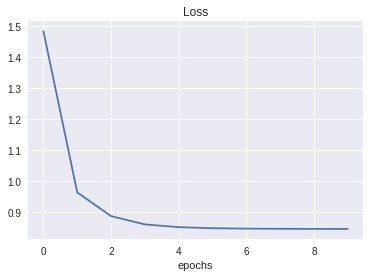

In [0]:

# DO NOT MODIFY THIS CELL
losses_toy, params = train(init_params, update_weights, x_toy, y_true_toy, batch_size=1, num_epoch=10, learning_rate=1)
W_learned, b_learned = params


In [0]:
# submit
pm.record('losses.toy', losses_toy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """Entry point for launching an IPython kernel.


Now that we have the `train` function, we can train our network on the 20 Newsgroups dataset.

### 3.9
#### (1 point)

Now we can test the implemented functions on our real dataset.

In the cell below, create the `X` and `y_true` matrices. During construction of the vocabulary, discard all tokens that appear less than 10 times (set the `min_count` argument to `10`)

---
__Notes__:
- You can use the functions `tokenize_doc`, `build_vocab`, `doc_to_multihot`, and `labels_to_onehot`


In [0]:
# create X and y_true here
docs_tokenized = [tokenize_doc(d) for d in dataset.data]
docs_vocab = build_vocab(docs_tokenized, min_count = 10)
docs_multihot = [doc_to_multihot(doc, docs_vocab) for doc in docs_tokenized]
docs_labels = labels_to_onehot(dataset.target_names)
x = docs_multihot
y_true = docs_labels

In [0]:
print('X:', x.shape)
print('y_true:', y_true.shape)

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('x.shape', x.shape)
pm.record('x.max', x.sum(axis=1).max())
pm.record('x.min', x.sum(axis=1).min())
pm.record('x.mean', x.sum(axis=1).mean())
pm.record('y_true.shape', y_true.shape)
pm.record('y_true.max', y_true.max())
pm.record('y_true.min', y_true.min())
pm.record('y_true.mean', y_true.mean())

### 3.10 
#### (2 points)

Using the implemented `train` function, now train a neural network on the Newsgroups dataset. Once the network is trained, complete the code in the `make_prediction` function that makes predictions for given inputs.

---
__Notes__:
- Recall that $\hat{y}_{pred} = \underset{j \in 1..k}{\text{argmax}}\left[\text{softmax}\left(\mathbf{z}\right)\right]$


In [0]:
# DO NOT MODIFY THIS CELL
losses, params = train(init_params, update_weights, x, y_true, batch_size=128, num_epoch=20, learning_rate=0.1, plot_loss=True)
W_learned, b_learned = params

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('losses', losses)

In [0]:
def make_prediction(x, W, b):
    """
        Make predictions for the given inputs x.

        x: np.array [N, d], inputs
        W: np.array, shape=[d, k], weights
        b: np.array, shape=[1, k], biases

        return: np.array of labels with shape [N]
    """
    # your code here
    z = linear(x, W, b)
    pred = np.argmax(softmax(z), axis = 0) 
    return pred

In [0]:
y_pred = make_prediction(x, W_learned, b_learned)

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('y_pred.shape', y_pred.shape)

In [0]:
accuracy = accuracy_score(dataset.target, y_pred)
print('Accuracy:', accuracy)

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('accuracy', accuracy)

## 4 Let's add more layers!

Similarly to the single-layer neural network, the two-layer neural network makes the following transformations:
$$ \mathbf{z}^{(1)} = W^{(1)}\mathbf{x} + \mathbf{b^{(1)}} $$
$$ \mathbf{a}^{(1)} = f\left(\mathbf{z}^{(1)}\right)$$

$$ \mathbf{z}^{(2)} = W^{(2)}\mathbf{a^{(1)}} + \mathbf{b^{(2)}} $$
$$ \mathbf{\hat{y}} = \text{softmax}\left(\mathbf{z}^{(2)}\right)$$
where $f$ is the activation of the first linear layer. In our network we will use the Rectified Linear Unit (ReLU) activation function defined as:

$$ f(x)=\text{ReLU(x)} = \max(0,x) $$

The corresponding formulas for computing the loss gradients are then as follows:

$$ \frac{\partial \mathcal{L}}{\partial W^{(2)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial  \mathbf{z}^{(2)}}{\partial W^{(2)}}$$

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(2)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{b}^{(2)}}$$


$$ \frac{\partial \mathcal{L}}{\partial W^{(1)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial \mathbf{z}^{(1)}} \cdot \frac{\partial\mathbf{z}^{(1)}}{\partial W^{(1)}}  $$

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(1)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial \mathbf{z}^{(1)}} \cdot \frac{\partial\mathbf{z}^{(1)}}{\partial \mathbf{b}^{(1)}}  $$

In these notations $W^{(1)} \in \mathbb{R}^{m\times d_2}$, $W^{(2)} \in \mathbb{R}^{d_2\times k}$,  $\mathbf{b}^{(1)} \in \mathbb{R}^{d_2}$ and $\mathbf{b}^{(2)} \in \mathbb{R}^{k}$.


### 4.1 
#### (2 points)

Simlarly to sections 3.2 and 3.6, perform the forward and backward propagation pass through the ReLU function (using its' definition).

---

__Notes__:
- In `relu_backward` the variable `a_grad` stands for  $\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial a^{(1)}}$


In [0]:
def relu(z):
    """
        Compute relu activation as max(z, 0)
        
        z: np.array, shape=[m, d]

        Return: np.array, shape=[m, d]
    """
    # your code here
    fun = np.maximum(0, z)
    return fun

In [0]:
def relu_backward(z, a_grad):
    """
        Return gradient of loss with respect to input z given the output gradient.

        z: np.array, shape=[m, d] input to relu, not the output
        
        return: gradient dL/dz np.array, shape=[m, d] //dL/dz1
    """
    # your code here
    a = relu(z)
    a[a>0]=1
    dLdz = np.dot(a_grad,a)
    return dLdz

### 4.2 
#### (1 point)

Perform the forward propagation of the two-layer neural network by completing the code in `neural_network`

In [0]:
def neural_network(x, W1, b1, W2, b2):
    """
        Use layers created above to define two-layer neural network with relu activation.

        x: np.array, shape=[m, n_features_tst]
        W1: np.array, shape=[m, d2] first layer weights
        W2: np.array, shape=[d2, k] second layer weights
        b1: np.array, shape=[1, d2] first layer bias
        b2: np.array, shape=[1, k] second layer bias

        return: tuple, output of the linear layer, output of the relu, output of the final linear layer
    """
    # your code here
    z1 = linear(x, W1, b1)
    z2 = relu(z)
    z3 = linear(z2, W2, b2)
    return z1, z2, z3

### 4.3
#### (3 points)

Compute the code in `neural_network_backward` that computes gradients of the loss function with respect to every weight.

---
__Notes__:
- You should call the already implemented backward functions in the cell below.

In [0]:
def neural_network_backward(x, W1, b1, W2, b2, z1, a1, z2, z2_grad):
    """
        Compute gradients of loss with respect to inputs x, W1, b1, W2, and b2.

        x: np.array, shape=[m, d] input
        W1: np.array, shape=[m, d2] first layer weights
        b1: np.array, shape=[1, d2] first layer bias
        W2: np.array, shape=[d2, k] second layer weights
        b2: np.array, shape=[1, k] second layer bias

        z1, z2, z3: np.array activations of linear, relu, and linear layers
        z3_grad: np.array, shape=[m, k] gradient of loss with respect to network output dL/dz3

        return: tuple: gradients dL/dW1, dL/db1, dL,dW2, dL/db2
    """
    a1_grad, W2_grad, b2_grad = None, None, None
    z1_grad = None
    x_grad, W1_grad, b1_grad = None, None, None

    return W1_grad, b1_grad, W2_grad, b2_grad


### 4.4
#### (3 points)

Complete the code and `update_neural_network_weights`.

---
__Notes__:
- The weights initialization is provided for you.


In [0]:
def init_neural_network_params(x, y_true):
    """
        Initialize weights and biases of two layer neural network, given input data.
        
        x: np.array, shape=[m, d] input
        y_true: np.array, shape=[m, k] true label one-hot
        
        return: list of np.array parameters
    """
    n_features = x.shape[1]
    n_classes = y_true.shape[1]
    n_middle = n_classes * 4  # we arbitrarily pick the middle layer size to be 4 times bigger than the output

    # Initialize W from normal distribution and b with zeros
    W1 = np.random.randn(n_features, n_middle) / n_features
    W2 = np.random.randn(n_middle, n_classes) / n_middle
    b1 = np.zeros(n_middle)
    b2 = np.zeros(n_classes)
    
    return [W1, W2, b1, b2]

def update_neural_network_weights(params, x, y_true, alpha, lam=0.001):
    """
        Given neural network parameters, update parameters and return loss.
        
        params: list of np.array parameters
        x: np.array, shape=[m, d] input
        y_true: np.array, shape=[m, k] output labels one-hot
        alpha: learning rate (float)
        lam: lambda regularization constant (float)
        
        return: float sum of cross entropy loss and L2 regularization losses
    """
    # place your code below
    W1, W2, b1, b2 = params
    z1, a1, z2 = None, None, None
    y = None
    loss = None
    z2_grad = None
    W1_grad, b1_grad, W2_grad, b2_grad = None, None, None, None
    reg_loss, [W1_reg_grad, W2_reg_grad, b1_reg_grad, b2_reg_grad] = None, [None, None, None, None]
    # place your code above
    W1 -= alpha * (W1_grad + W1_reg_grad)
    W2 -= alpha * (W2_grad + W2_reg_grad)
    b1 -= alpha * (b1_grad + b1_reg_grad)
    b2 -= alpha * (b2_grad + b2_reg_grad)
    return loss + reg_loss


### 4.5
#### (1 point)
Complete the code in `make_prediction_network` function similarly to the section 3.10.

In [0]:
def make_prediction_network(x, W1, b1, W2, b2):
    """
        Make predictions for the given inputs x.

        x: np.array, shape=[m, d] input
        W1: np.array, shape=[m, d2] first layer weights
        b1: np.array, shape=[1, d2] first layer bias
        W2: np.array, shape=[d2, k] second layer weights
        b2: np.array, shape=[1, k] second layer bias

        return: np.array of labels with shape [N]
    """
    # your code here
    return 

In [0]:
# Test the neural network on the toy dataset
losses_nn, params_nn = train(init_neural_network_params, update_neural_network_weights, x_toy, y_true_toy, batch_size=1, num_epoch=1000, learning_rate=0.1, plot_loss=True, lam=0.001, verbose=False)

### 4.6 Let's train!

In [0]:
# Now, we train on the real dataset!
losses_nn, params_nn = train(init_neural_network_params, update_neural_network_weights, x, y_true, batch_size=128, num_epoch=20, learning_rate=0.1, plot_loss=True, lam=0.0, plot_per_epoch=False)
W1_learned_nn, W2_learned_nn, b1_learned_nn, b2_learned_nn = params_nn

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('losses_nn', losses_nn)

In [0]:
y_pred_nn = make_prediction_network(x, W1_learned_nn, b1_learned_nn, W2_learned_nn, b2_learned_nn)

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('y_pred_nn.shape', y_pred_nn.shape)

In [0]:
accuracy_nn = accuracy_score(dataset.target, y_pred_nn)
print('Accuracy NN:', accuracy_nn)

In [0]:
# DO NOT MODIFY THIS CELL
pm.record('accuracy.nn', accuracy_nn)